In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte # Untuk memuat gambar dan konversi tipe data jika perlu
from skimage.util import random_noise # Untuk mensimulasikan noise

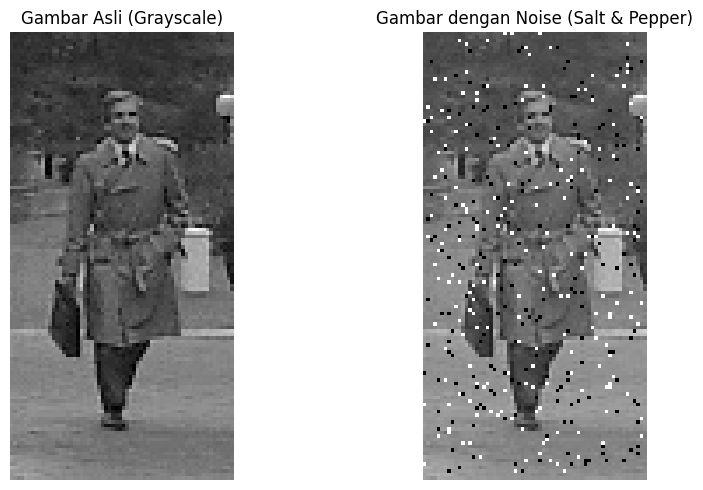

In [ ]:
image_path = "/CCTV Gender Classifier Dataset/MALE/00007_male_fore.jpg"

original_image_rgb = io.imread(image_path)
original_image_gray = cv2.cvtColor(original_image_rgb, cv2.COLOR_RGB2GRAY) # konversi ke grayscale untuk filter

# normalisasi gambar
normalized_image = original_image_gray / 255.0 

amount = 0.05  
s_vs_p = 0.5   

# buat salinan gambar untuk ditambahkan noise
noisy_image = np.copy(normalized_image)

# tambah Salt noise
num_salt = np.ceil(amount * normalized_image.size * s_vs_p)
coords = [np.random.randint(0, i - 1, int(num_salt))
          for i in normalized_image.shape]
noisy_image[coords[0], coords[1]] = 1 # Nilai 1 untuk piksel putih (salt)

# tambah pepper noise
num_pepper = np.ceil(amount * normalized_image.size * (1. - s_vs_p))
coords = [np.random.randint(0, i - 1, int(num_pepper))
          for i in normalized_image.shape]
noisy_image[coords[0], coords[1]] = 0 # Nilai 0 untuk piksel hitam (pepper)

# ubah kembali gambar noise ke format 0-255 uint8 agar bisa ditampilkan dan diproses oleh OpenCV
noisy_image_uint8 = img_as_ubyte(noisy_image)

# tampilkan gambar asli dan noise
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(original_image_gray, cmap='gray')
plt.title('Gambar Asli (Grayscale)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(noisy_image_uint8, cmap='gray')
plt.title('Gambar dengan Noise (Salt & Pepper)')
plt.axis('off')

plt.tight_layout()
plt.show()

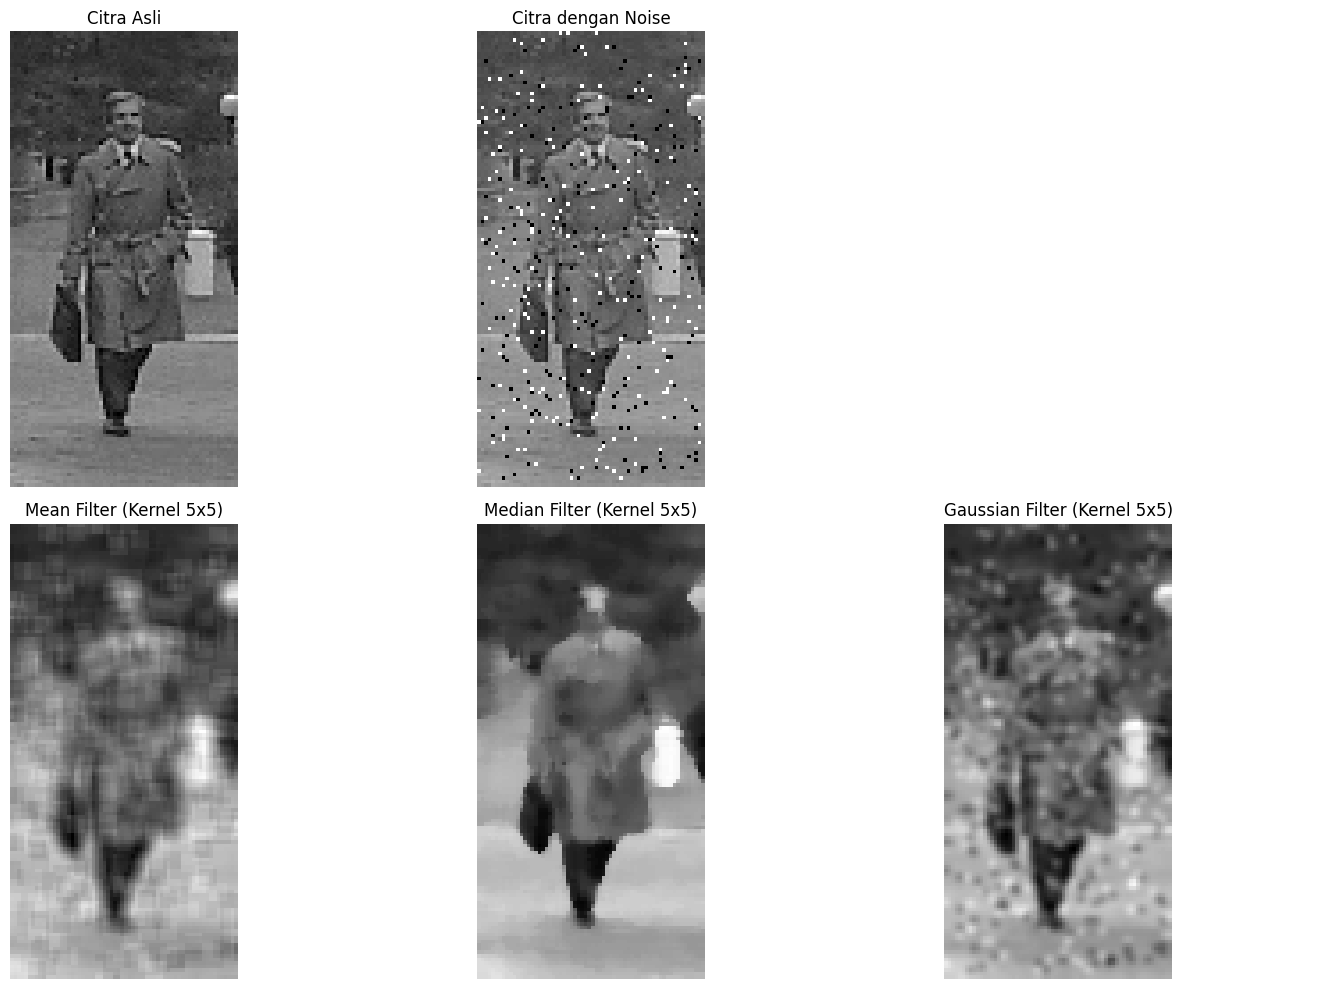

In [10]:
# ukuran kernel filter harus ganjil
kernel_size_mean = (5, 5)
kernel_size_median = 5 # Untuk median blur, hanya satu nilai ganjil
kernel_size_gaussian = (5, 5)
sigma_gaussian = 0 # sigma nol akan dihitung otomatis dari ukuran kernel jika kernel_size > 0

# Filter Mean 
# cv2.blur() menghitung rata-rata piksel dalam jendela kernell
mean_filtered_image = cv2.blur(noisy_image_uint8, kernel_size_mean)

# Filter Median
# cv2.medianBlur() mengganti piksel dengan nilai median di dalam kernel, efektif untuk salt & pepper
median_filtered_image = cv2.medianBlur(noisy_image_uint8, kernel_size_median)

# Gaussian Blur
# cv2.GaussianBlur() menggunakan fungsi Gaussian untuk menghitung bobot rata-rata,
gaussian_filtered_image = cv2.GaussianBlur(noisy_image_uint8, kernel_size_gaussian, sigma_gaussian)

plt.figure(figsize=(15, 10)) 

plt.subplot(2, 3, 1)
plt.imshow(original_image_gray, cmap='gray')
plt.title('Citra Asli')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(noisy_image_uint8, cmap='gray')
plt.title('Citra dengan Noise')
plt.axis('off')

plt.subplot(2, 3, 3)
plt.axis('off') # memastikan tidak ada axis jika plot kosong

plt.subplot(2, 3, 4) 
plt.imshow(mean_filtered_image, cmap='gray')
plt.title(f'Mean Filter (Kernel {kernel_size_mean[0]}x{kernel_size_mean[1]})')
plt.axis('off')

plt.subplot(2, 3, 5) # Baris 2, Kolom 3, Plot ke-5
plt.imshow(median_filtered_image, cmap='gray')
plt.title(f'Median Filter (Kernel {kernel_size_median}x{kernel_size_median})')
plt.axis('off')

plt.subplot(2, 3, 6) 
plt.imshow(gaussian_filtered_image, cmap='gray')
plt.title(f'Gaussian Filter (Kernel {kernel_size_gaussian[0]}x{kernel_size_gaussian[1]})')
plt.axis('off')

plt.tight_layout() 
plt.show() 

In [ ]:
# simpan gambar hasil filtering
import os
output_dir = "/smoothed_images"
os.makedirs(output_dir, exist_ok=True)

cv2.imwrite(os.path.join(output_dir, "original_image_gray.png"), original_image_gray)
cv2.imwrite(os.path.join(output_dir, "noisy_image_salt_pepper.png"), noisy_image_uint8)
cv2.imwrite(os.path.join(output_dir, "mean_filtered_image.png"), mean_filtered_image)
cv2.imwrite(os.path.join(output_dir, "median_filtered_image.png"), median_filtered_image)
cv2.imwrite(os.path.join(output_dir, "gaussian_filtered_image.png"), gaussian_filtered_image)

print(f"Semua gambar hasil smoothing telah disimpan di: {output_dir}")


Semua gambar hasil smoothing telah disimpan di: /kaggle/working/smoothed_images


# Peredam Noise pada Citra CCTV: Kelebihan & Kekurangan Filter Dasar


### 1. Mean Filter (Filter Rata-Rata)

Filter ini bekerja dengan mengganti setiap nilai piksel dalam citra dengan nilai rata-rata dari piksel-piksel tetangganya (termasuk piksel itu sendiri) di dalam jendela (kernel) yang ditentukan. Efeknya adalah penghalusan citra dengan meratakan variasi intensitas cahaya.

- Kelebihan: Cepat dan efektif untuk Noise Gaussian (noise acak/pasir)
- Kekurangan: Membuat citra buram signifikan, sangat buruk dalam menjaga detail tepi. Tidak efektif untuk noise Salt & Pepper (bintik putih/hitam)

### 2. Median Filter (Filter Median)

Berbeda dengan Mean Filter, metode ini bersifat non-linear. Ia mengganti nilai setiap piksel dengan nilai median (nilai tengah setelah diurutkan) dari piksel-piksel di dalam jendela (kernel) yang ditentukan. Filter ini sangat efektif untuk noise impulsif karena nilai outlier tidak akan menjadi nilai tengah.

- Kelebihan: Sangat efektif untuk noise Salt & Pepper, menjaga detail tepi jauh lebih baik daripada Mean Filter
- Kekurangan: Lebih lambat. Kurang efektif untuk noise Gaussian

### 3. Gaussian Filter (Filter Gaussian)

Filter ini adalah filter linear yang menggunakan fungsi Gaussian (distribusi normal) untuk menghitung bobot rata-rata piksel di dalam jendela (kernel). Piksel yang lebih dekat ke pusat kernel akan mendapatkan bobot yang lebih besar. Hasilnya adalah blur yang lebih alami dan penghalusan yang efektif untuk noise terdistribusi secara normal.

- Kelebihan: Sangat efektif untuk Noise Gaussian, menghasilkan blur yang lebih halus dan alami. Tingkat penghalusan bisa diatur
- Kekurangan: Tetap menyebabkan pengaburan tepi (meskipun lebih baik dari Mean). Kurang efektif untuk noise Salt & Pepper
